# Behavior of $\epsilon \mapsto \psi^\epsilon$

In [1]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from scipy.integrate import quad

### Definition of source and target:
* $\rho$ is the Lebesgue measure on the unit segment $[0, 1]$
* $\mu = \frac{1}{5} \sum_{i=1}^{5} \delta_{y_i}$ is a uniform discrete measure with support of size $5$ included in $[0, 1]$. We denote $N=5$.

Y = [0.15601864 0.37454012 0.59865848 0.73199394 0.95071431]


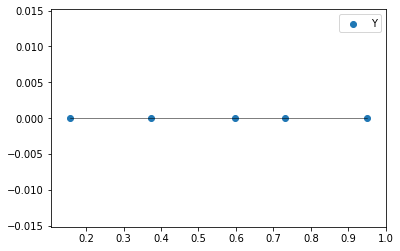

In [2]:
n_target = 5
b = np.ones(n_target)/n_target
rng = np.random.RandomState(42)
Y_target = np.sort(rng.rand(n_target))
print("Y =", Y_target)

plt.scatter(Y_target, np.zeros(n_target), label="Y")
plt.plot(Y_target, np.zeros(n_target), c="k", lw=0.5)
plt.legend()
plt.savefig('support-mu.pdf')  
plt.show()

### Solve unregularized OT
We find $\psi^0$ recursively using the following relation: for $k \in \{1, \dots, N-1\}$ and $x_k = \frac{k}{N}$,
$$ x_k y_k - \psi^0_k = x_k y_{k+1} - \psi^0_{k+1}. $$
Then normalize so that $\langle \psi^0, \mathbb{1}_N \rangle = 0$.

In [3]:
psi_0 = np.zeros(n_target)
for k in range(n_target-1):
    psi_0[k+1] = (k+1)/n_target*(Y_target[k+1]-Y_target[k]) + psi_0[k]
    
def T(x):
    return np.argmax(x*Y_target - psi_0)

xx = np.linspace(0, 1, 15)
for x in xx:
    print("T({}) = y_{}".format(x, T(x)+1))
    
psi_0 = psi_0 - (1/n_target)*np.sum(psi_0)

print("\npsi_0 =", psi_0)

print("\n<psi_0, 1_N> =", np.sum(psi_0))

T(0.0) = y_1
T(0.07142857142857142) = y_1
T(0.14285714285714285) = y_1
T(0.21428571428571427) = y_2
T(0.2857142857142857) = y_2
T(0.3571428571428571) = y_2
T(0.42857142857142855) = y_3
T(0.5) = y_3
T(0.5714285714285714) = y_3
T(0.6428571428571428) = y_4
T(0.7142857142857142) = y_4
T(0.7857142857142857) = y_4
T(0.8571428571428571) = y_5
T(0.9285714285714285) = y_5
T(1.0) = y_5

psi_0 = [-0.15574761 -0.11204332 -0.02239597  0.0576053   0.2325816 ]

<psi_0, 1_N> = -5.551115123125783e-17


### Solve regularized OT for a given regularization

Here we solve the following optimization problem:

$$ (1) \qquad \min_{\psi \in \mathbb{R}^N} F^\epsilon(\psi), $$
where $$F^\epsilon(\psi) = \int_0^1 \epsilon \log \left( \sum_{i=1}^N e^{\frac{xy_i - \psi_i}{\epsilon}} \right) dx + \langle \psi, \mathbb{1}_N \rangle + \epsilon = \int_0^1 f^\epsilon(x, \psi) dx + \langle \psi, \mathbb{1}_N \rangle + \epsilon.$$
The function $F^\epsilon$ is convex on $\mathbb{R}^N$ and stricly convex on $(\mathbb{1}_N)^\perp$. We use the gradient descent algorithm to solve $(1)$. To do so, notice that the gradient of $F^\epsilon$ is obtained using the formulas:
$$ \frac{ \partial F^\epsilon}{\partial \psi_i} (\psi) = \mu - \int_0^1 \frac{ e^{\frac{xy_i - \psi_i}{\epsilon}} }{ \sum_{j=1}^N e^{\frac{xy_j - \psi_j}{\epsilon}} } dx.$$

Both the cost function $F^\epsilon$ and the gradient $\nabla F^\epsilon = (\frac{ \partial F^\epsilon}{\partial \psi_i})_{i=1, \dots, N}$ are computed using ```scipy.integrate.quad```.

In [4]:
def h(x, j, psi, eps, b, Y_target):
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    return (b - pi).flatten()[j]

def f(x, psi, eps, b, Y_target):
    r = x*Y_target - psi
    max_r = np.max(r)
    r -= max_r
    return max_r + eps*np.log(np.sum(np.exp(r/eps)))

def get_cost(psi, eps, b, Y_target):
    A = quad(f, 0, 1, args=(psi, eps, b, Y_target))[0]
    B = np.sum(b*psi)
    return A + B + eps

def gradient(psi, eps, b, Y_target):
    grad = np.zeros(len(Y_target))
    for j in range(len(Y_target)):
        grad[j] = quad(h, 0, 1, args=(j, psi, eps, b, Y_target))[0]
    return grad
        
def gradient_descent(psi_init, eps, b, Y_target, lr, num_iter):
    print("eps =", eps)
    psi = psi_init
    log_cost = []
    for k in tqdm(range(num_iter)):
        psi -= lr*gradient(psi, eps, b, Y_target)
        log_cost.append(get_cost(psi, eps, b, Y_target))
    return psi, log_cost

def plot_cost(num_iter, log_cost):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(num_iter), log_cost)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.subplot(1, 2, 2)
    plt.loglog(np.arange(num_iter), log_cost)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.show()
    return None

We use the defined algorithms to solve the regularized OT problem with $\epsilon=10^{-2}$.

eps = 0.01


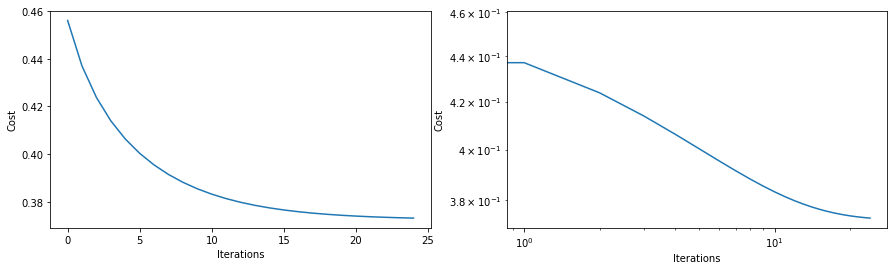

psi^\eps =
[-0.13865939 -0.10219076 -0.02435276  0.04892984  0.21627307]
psi^0 =
[-0.15574761 -0.11204332 -0.02239597  0.0576053   0.2325816 ]


In [5]:
eps = 1e-2
lr = eps**(2/3)
num_iter = 25
psi_init = 10*np.ones(n_target)

psi_eps, log_cost = gradient_descent(psi_init, eps, b, Y_target, lr=lr, num_iter=num_iter)
psi_eps = psi_eps - (1/n_target)*np.sum(psi_eps)

plot_cost(num_iter, log_cost)

print("psi^\eps =")
print(psi_eps)
print("psi^0 =")
print(psi_0)

Observe the functions $x \mapsto \pi^\epsilon_{i, x}$ for $i \in \{1, \dots, N\}$:

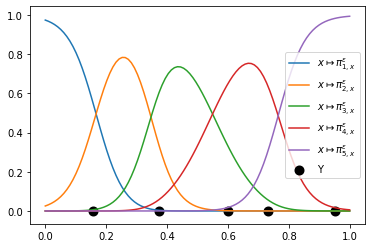

In [6]:
def pi_eps(x, i, psi, eps, b, Y_target):
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    return pi[i]

xx = np.linspace(0, 1, 100)
for i in range(n_target):
    pi_i = np.array([pi_eps(x, i, psi_eps, eps, b, Y_target) for x in xx])
    title = r"$x \mapsto \pi^\epsilon_{" + str(i+1) + ", x}$"
    plt.plot(xx, pi_i, label=title)
    
plt.scatter(Y_target, np.zeros(n_target), label="Y", lw=4, c="k")
plt.legend()
plt.savefig('example-pi-eps-1e-2.pdf')  
plt.show()

### Solve OT for different regularizations

Here we solve the regularized OT problem for different regularization parameters $(\epsilon_j)_{j = 1, \dots, M}$ (that are indexed increasingly). 

Note that we choose a learning rate for gradient descent of $\epsilon^{2/3}$. This was set manually to ensure full optimization of the different problems.

We also leverage our stability result concerning the mapping $\epsilon \mapsto \psi^\epsilon$ and use a "scaling" scheme: we start by solving the regularized OT problem for the biggest regularization parameter $\epsilon_M$. Then when solving the regularized OT problem for $\epsilon_j$, we start the optimization algorithm with the solution $\psi^{\epsilon_{j+1}}$ of the previous OT problem with regularization $\epsilon_{j+1}$. This ensures faster convergence of the different optimization procedures.

i = 0
eps = 398.1071705534973



[-0.20317393 -0.09392678  0.01812885  0.08479945  0.1941724 ]


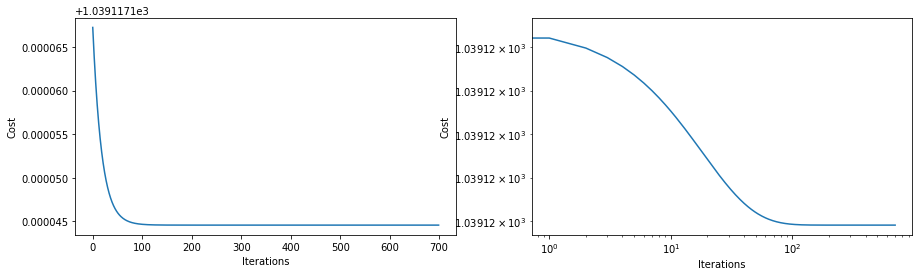

i = 1
eps = 255.20933255599635



[-0.20316872 -0.09392918  0.01812446  0.08479667  0.19417677]


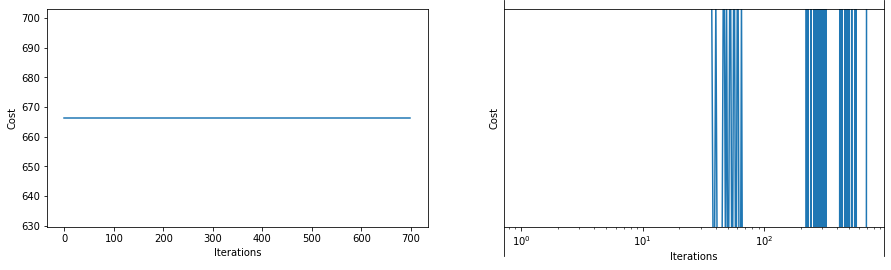

i = 2
eps = 163.60369327968363



[-0.20316059 -0.09393293  0.01811761  0.08479233  0.19418359]


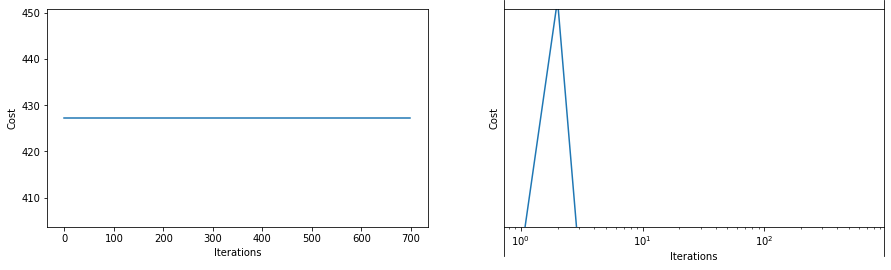

i = 3
eps = 104.87926983971087



[-0.20314792 -0.09393877  0.01810692  0.08478555  0.19419422]


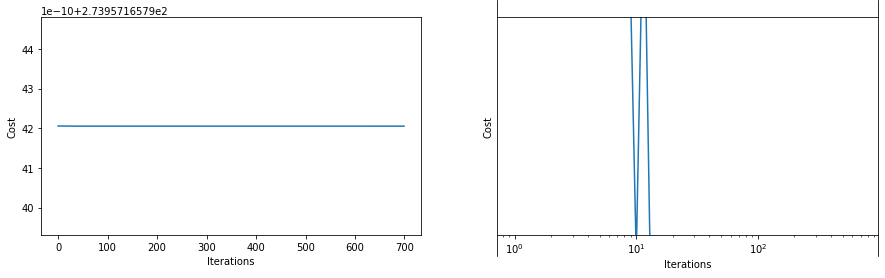

i = 4
eps = 67.23357536499334



[-0.20312815 -0.09394788  0.01809025  0.08477499  0.1942108 ]


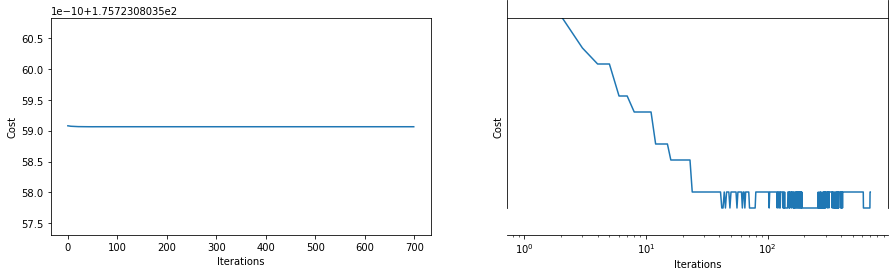

i = 5
eps = 43.10054468598798



[-0.20309731 -0.0939621   0.01806424  0.08475851  0.19423666]


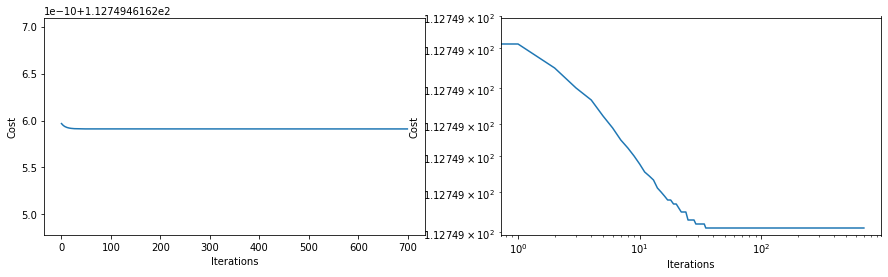

i = 6
eps = 27.629899825260118



[-0.20304921 -0.09398428  0.01802367  0.0847328   0.19427701]


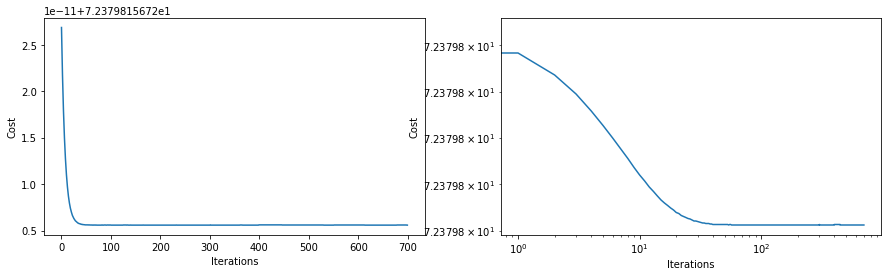

i = 7
eps = 17.71233681420492



[-0.20297417 -0.09401888  0.01796039  0.0846927   0.19433995]


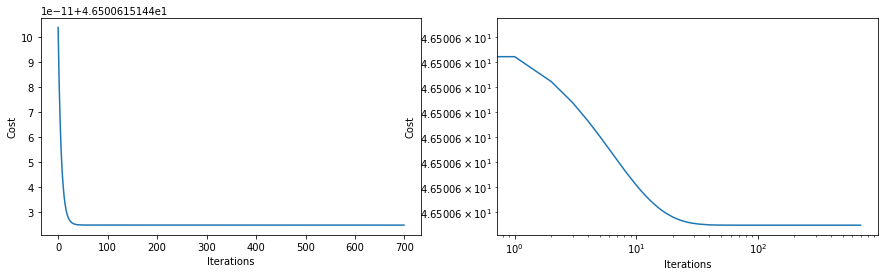

i = 8
eps = 11.354615015036018



[-0.20285711 -0.09407284  0.01786169  0.08463015  0.19443812]


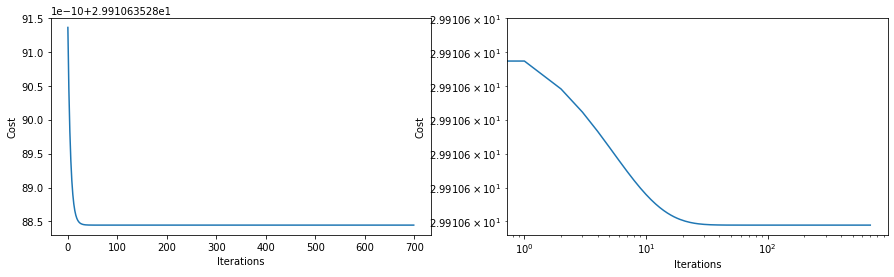

i = 9
eps = 7.278953843983146



[-0.20267453 -0.09415702  0.01770772  0.08453258  0.19459125]


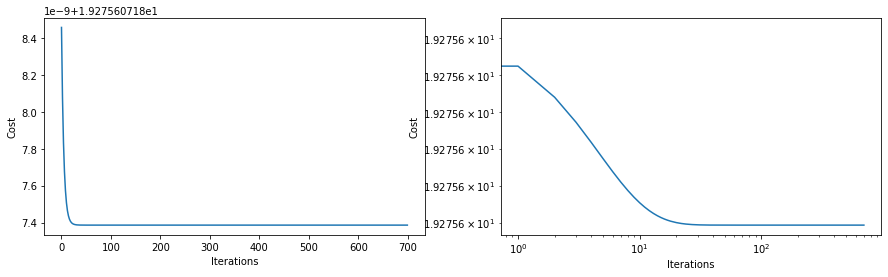

i = 10
eps = 4.666223292703069



[-0.20238978 -0.09428829  0.01746759  0.08438041  0.19483007]


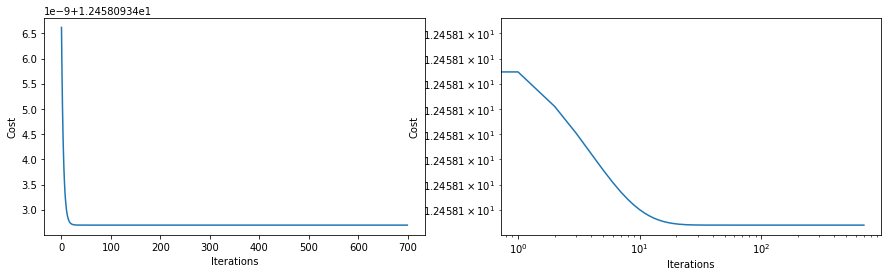

i = 11
eps = 2.9913144504086913



[-0.20194582 -0.09449293  0.0170932   0.08414317  0.19520238]


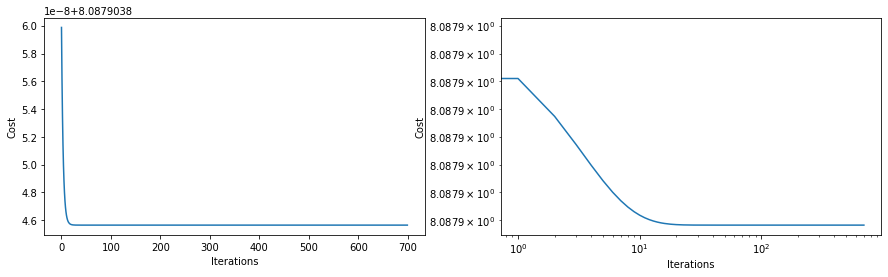

i = 12
eps = 1.9176026477808004



[-0.20125414 -0.09481167  0.01650988  0.08377358  0.19578235]


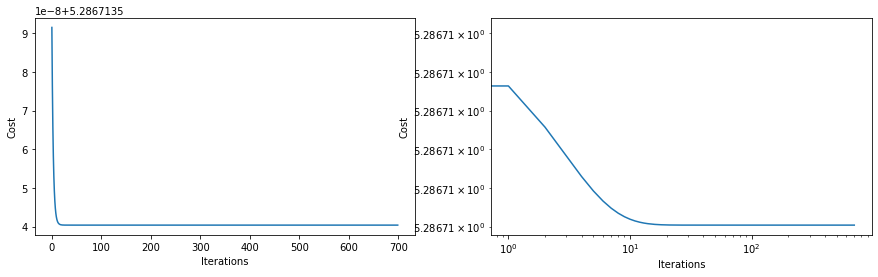

i = 13
eps = 1.2292923314275885



[-0.20017844 -0.095307    0.01560259  0.08319887  0.19668398]


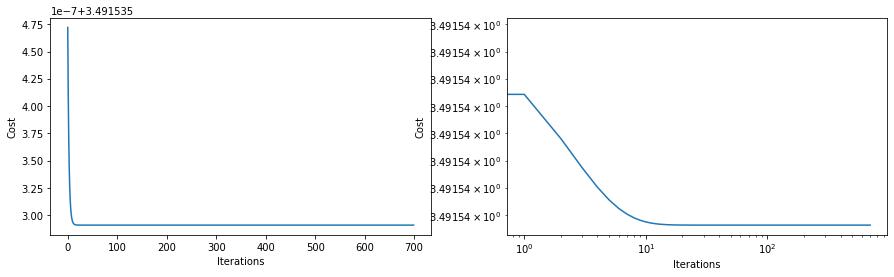

i = 14
eps = 0.7880462815669912



[-0.19851272 -0.09607268  0.01419727  0.08230921  0.19807891]


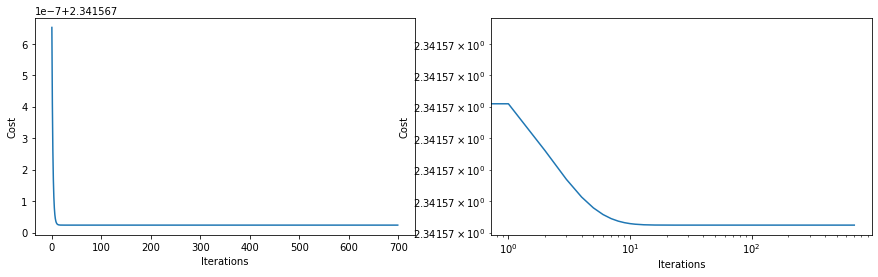

i = 15
eps = 0.5051824745139091



[-0.19595977 -0.09724121  0.012042    0.08094675  0.20021223]


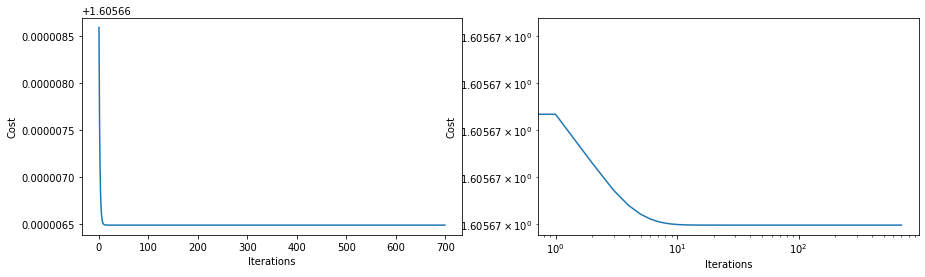

i = 16
eps = 0.323850690658073



[-0.19213976 -0.0989721   0.00881201  0.07891168  0.20338817]


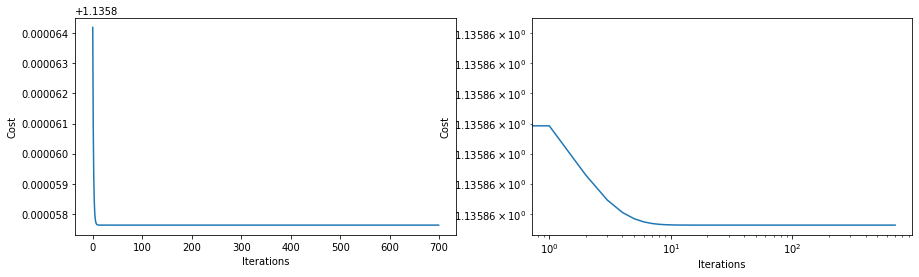

i = 17
eps = 0.20760670674616458



[-0.18671807 -0.10137186  0.00421158  0.07603396  0.20784438]


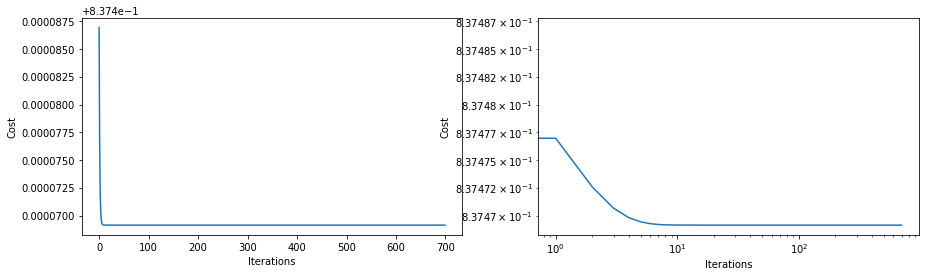

i = 18
eps = 0.13308770346731857



[-0.17978384 -0.10428848 -0.00171443  0.07237583  0.21341091]


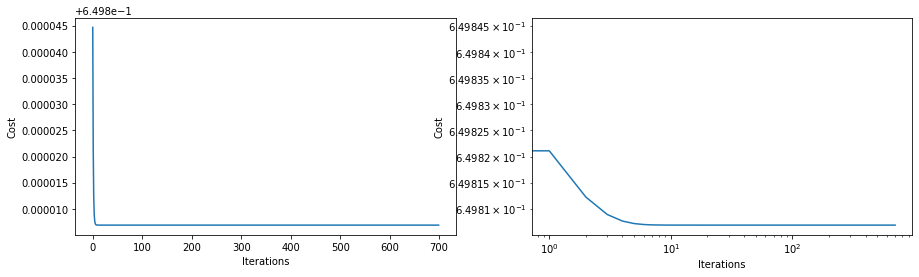

i = 19
eps = 0.08531678524172806



[-0.17230009 -0.10714314 -0.00818183  0.06844342  0.21918164]


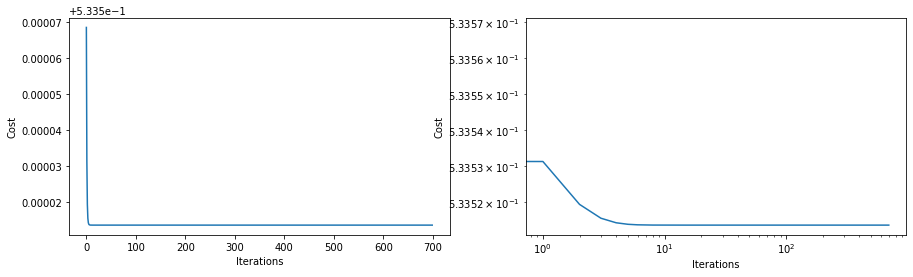

i = 20
eps = 0.0546929104218151



[-0.16578316 -0.10930516 -0.01385012  0.06494789  0.22399055]


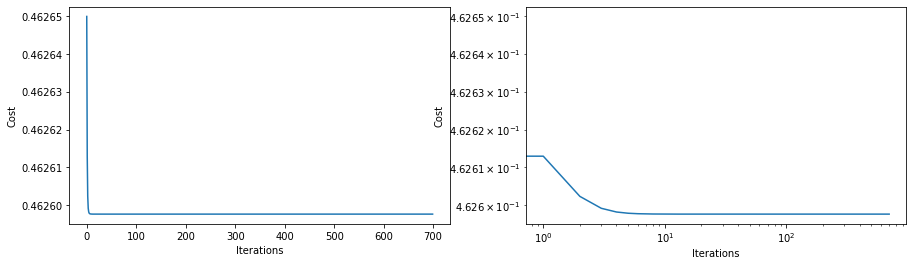

i = 21
eps = 0.035061265399691274



[-0.16117269 -0.11072727 -0.01777146  0.06222703  0.22744439]


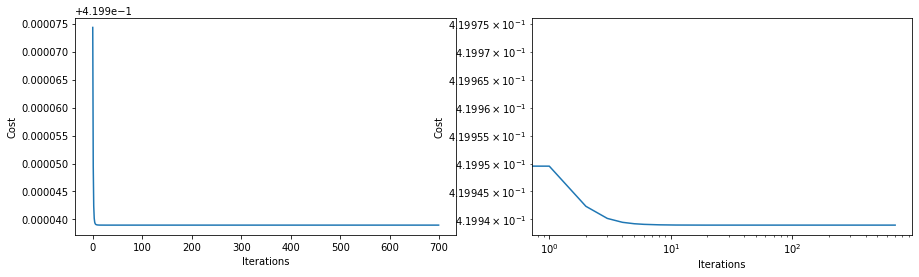

i = 22
eps = 0.022476264692201618



[-0.15839494 -0.11166286 -0.02001977  0.06022298  0.22985459]


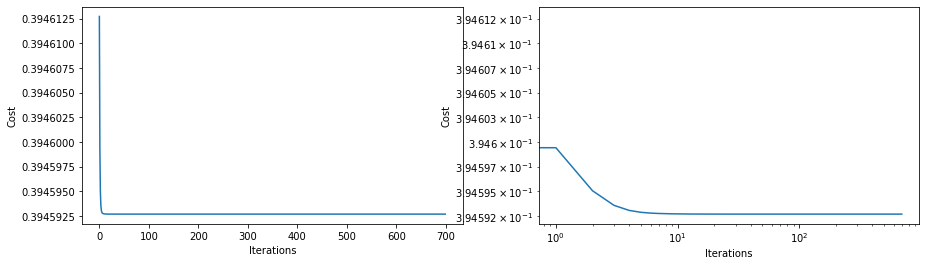

i = 23
eps = 0.014408563660065654



[-0.15685597 -0.11211287 -0.02128769  0.05882671  0.23142981]


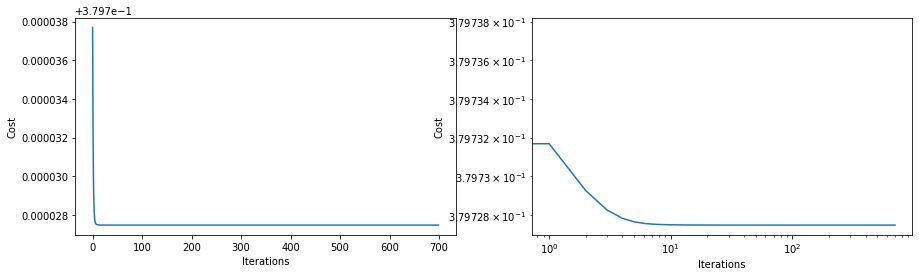

i = 24
eps = 0.009236708571873866



[-0.15607256 -0.11215093 -0.02202715  0.05799829  0.23225236]


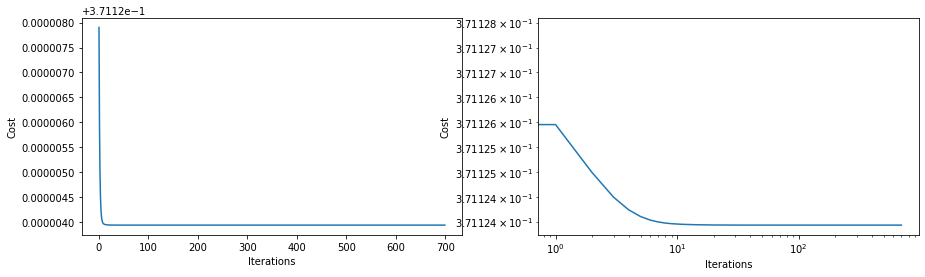

i = 25
eps = 0.005921255390514012



[-0.15579647 -0.11207422 -0.02233331  0.05767135  0.23253265]


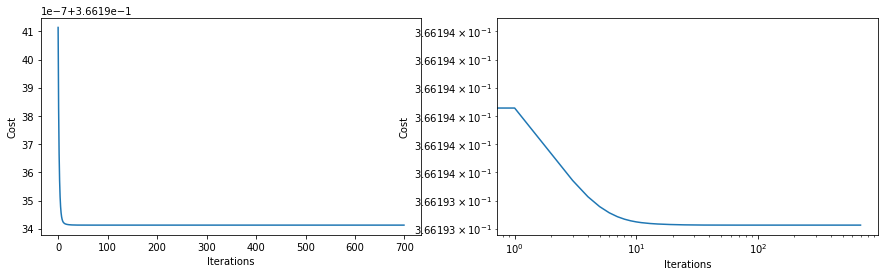

i = 26
eps = 0.003795861385781318



[-0.15575029 -0.11204568 -0.02239223  0.05760927  0.23257892]


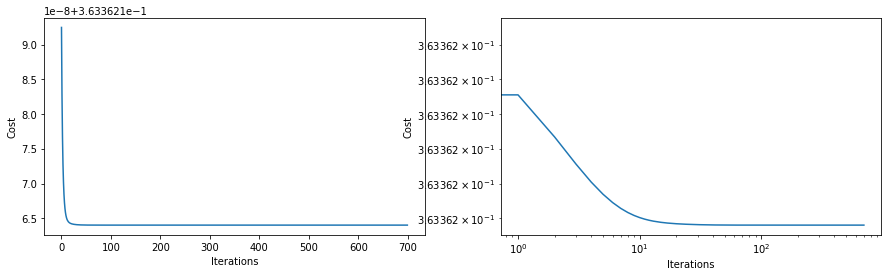

i = 27
eps = 0.002433362979605388



[-0.15574765 -0.11204335 -0.02239592  0.05760536  0.23258156]


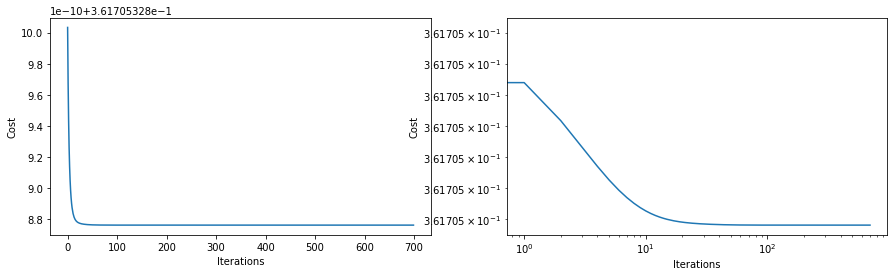

i = 28
eps = 0.0015599240300749866



[-0.15574761 -0.11204332 -0.02239597  0.0576053   0.2325816 ]


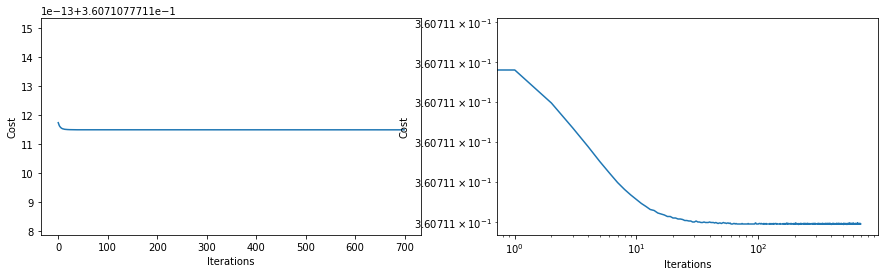

i = 29
eps = 0.001



[-0.15574761 -0.11204332 -0.02239597  0.0576053   0.2325816 ]


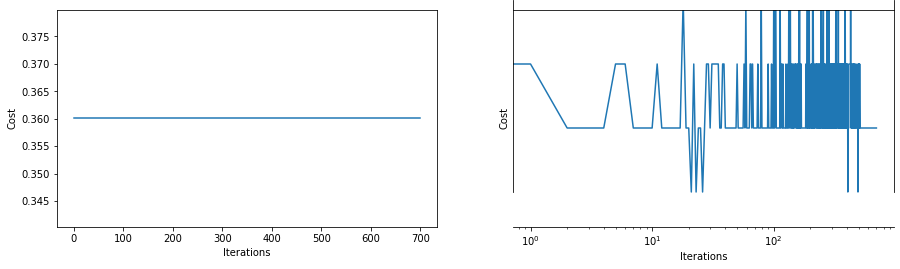

In [7]:
nb_eps = 30 
epsilons = np.logspace(-3, 2.6, nb_eps) 
log_psi = np.zeros((n_target, nb_eps))

for i in range(nb_eps):
    
    print("i =", i)
    num_iter = 700
    eps = epsilons[nb_eps - 1 - i]  
    lr = eps**(2/3) 
    
    # initialize potential
    if i==0:
        psi_init = np.zeros(n_target)
    else:
        psi_init = log_psi[:, nb_eps - i].copy()
    
    # compute potential using gradient descent
    psi_eps, log_cost = gradient_descent(psi_init, eps, b, Y_target, lr=lr, num_iter=num_iter)
    
    # normalize potential
    psi_eps = psi_eps - (1/n_target)*np.sum(psi_eps)
    print(psi_eps)
    
    # plot log of cost function
    plot_cost(num_iter, log_cost)
    
    # store potential
    log_psi[:, nb_eps - 1 - i] = psi_eps.copy()

### Observe behavior w.r.t. $\epsilon$

We can first observe the rate of convergence of $\psi^\epsilon$ to $\psi^0$ as $\epsilon$ goes to $0$.

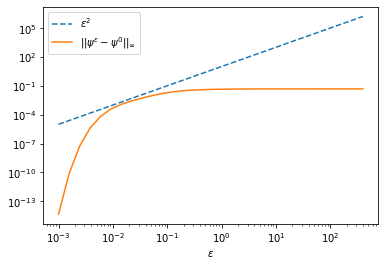

In [8]:
differences_psi = np.linalg.norm(log_psi - psi_0.reshape((-1, 1)), axis=0, ord=np.inf)

comparison = np.array([10*eps**2 for eps in epsilons])
plt.loglog(epsilons, comparison, "--", label=r"$\epsilon^2$")

plt.loglog(epsilons, differences_psi, label=r"$||\psi^\epsilon - \psi^0||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.legend()
plt.savefig('psi-eps-psi-0.pdf')  
plt.show()

We now observe a proxy for the derivatives and plot the quantity $|| \frac{\psi^{\epsilon_{j+1}} - \psi^{\epsilon_{j}}}{\epsilon_{j+1} - \epsilon_{j}} ||_\infty$ vs. $\frac{\epsilon_j + \epsilon_{j+1}}{2}$. This stands for a proxy of the plot $|| \dot{\psi^\epsilon} ||_\infty$ vs. $\epsilon$.

We compare this to the functions $\epsilon \mapsto \epsilon^2$ (which should control $\epsilon\mapsto || \dot{\psi^\epsilon} ||_\infty$ as $\epsilon \to 0$) and to $\epsilon \mapsto \frac{1}{\epsilon}$ (which should control $\epsilon\mapsto || \dot{\psi^\epsilon} ||_\infty$ as $\epsilon \to \infty$).

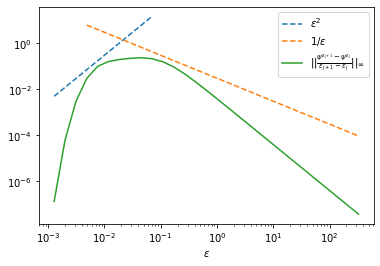

In [9]:
mean_epsilons = (epsilons[:-1] + epsilons[1:])/2

plt.loglog(mean_epsilons[:10], 3000*mean_epsilons[:10]**2, "--", label=r"$\epsilon^2$")
plt.loglog(mean_epsilons[3:], 3e-2/mean_epsilons[3:], "--", label=r"$1/\epsilon$")


derivatives_psi = (log_psi[:, 1:] - log_psi[:, :-1])/(epsilons[1:] - epsilons[:-1])
norm_derivatives_psi = np.linalg.norm(derivatives_psi, axis=0, ord=np.inf)
plt.loglog(mean_epsilons, norm_derivatives_psi, label=r"$||\frac{\psi^{\epsilon_{j+1}} - \psi^{\epsilon_{j}}}{\epsilon_{j+1} - \epsilon_{j}}||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.legend()
plt.savefig('approx-derivatives-psi.pdf')  
plt.show()

Compute the *true* derivatives using the formula
$$ \dot{\psi^\epsilon} = - \left( \int_0^1 M(\pi^\epsilon_x) dx \right)^{-1} \left( \int_0^1 M(\pi^\epsilon_x) \log \pi^\epsilon_x \right),$$
where $M(\pi^\epsilon_x) = \mathrm{diag}(\pi^\epsilon_x) - \pi^\epsilon_x (\pi^\epsilon_x)^\top$.

In [10]:
def M_ij(x, i, j, psi, eps, b, Y_target): 
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    if i==j:
        return pi[i]*(1 - pi[i])
    else:
        return -pi[i]*pi[j]
    
def Mlog_i(x, i, psi, eps, b, Y_target): 
    n_target = len(Y_target)
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    M_i = np.zeros(n_target)
    for j in range(n_target):
        if j==i: M_i[j] = pi[i]*(1 - pi[i])
        else: M_i[j] = -pi[i]*pi[j]
    return np.sum(M_i*r)

def Hessian_K_eps(psi, eps, b, Y_target):
    n_target = len(Y_target)
    mat = np.zeros((n_target, n_target))
    for i in range(n_target):
        mat[i, i] = quad(M_ij, 0, 1, args=(i, i, psi, eps, b, Y_target))[0]
        for j in range(i+1, n_target):
            mat[i, j] = quad(M_ij, 0, 1, args=(i, j, psi, eps, b, Y_target))[0]
            mat[j, i] = mat[i, j]
    return (1/eps)*mat

def der_epsilon_K_eps(psi, eps, b, Y_target):
    n_target = len(Y_target)
    vect = np.zeros(n_target)
    for i in range(n_target):
        vect[i] = quad(Mlog_i, 0, 1, args=(i, psi, eps, b, Y_target))[0]
    return (1/eps)*vect

def get_dot_psi(psi, eps, b, Y_target):
    mat = Hessian_K_eps(psi, eps, b, Y_target)
    vect = der_epsilon_K_eps(psi, eps, b, Y_target)
    dot_psi = np.linalg.solve(mat, -vect)
    return dot_psi - (1/n_target)*np.sum(dot_psi)

Observe Theorem 3.2:

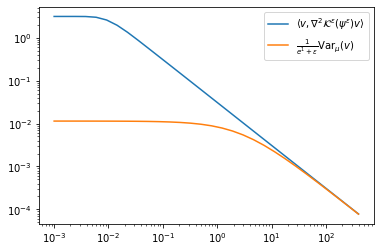

In [11]:
v = np.random.rand(n_target)
var_v = np.var(v)

hessian_products = np.zeros(nb_eps)
for i in range(nb_eps):
    hessian_products[i] = v.dot(Hessian_K_eps(log_psi[:, i], epsilons[i], b, Y_target).dot(v))
    
plt.loglog(epsilons, hessian_products, label=r'$\langle v, \nabla^2 \mathcal{K}^\epsilon (\psi^\epsilon) v\rangle$')
plt.loglog(epsilons, var_v/(np.exp(1)+epsilons), label=r'$\frac{1}{e^1 + \epsilon} \mathrm{Var}_\mu(v)$')
plt.legend()
plt.savefig('strong-convexity.pdf')  
plt.show()

Observe Theorem 3.3:

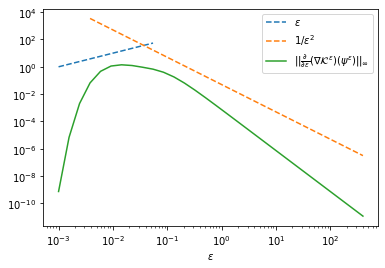

In [12]:
log_der_epsilon_K_eps = np.zeros((n_target, nb_eps))
for i in range(nb_eps):
    log_der_epsilon_K_eps[:, i] = der_epsilon_K_eps(log_psi[:, i], epsilons[i], b, Y_target) 
    
plt.loglog(epsilons[:10], 1000*epsilons[:10]**1, "--", label=r"$\epsilon$")
plt.loglog(epsilons[3:], 5e-2/epsilons[3:]**2, "--", label=r"$1/\epsilon^2$")

norm_der_epsilon_K_eps = np.linalg.norm(log_der_epsilon_K_eps, axis=0, ord=np.inf)
plt.loglog(epsilons, norm_der_epsilon_K_eps, label=r"$||\frac{\partial}{\partial \epsilon}(\nabla \mathcal{K}^\epsilon)(\psi^\epsilon)||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.legend()
plt.savefig('bound-second-term-ode.pdf')  
plt.show()

Observe Theorem 2.1:

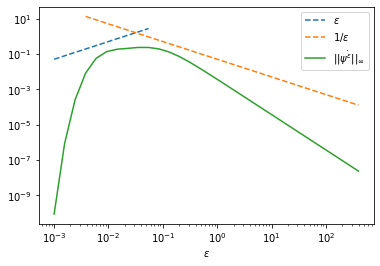

In [16]:
log_dot_psi = np.zeros((n_target, nb_eps))
for i in range(nb_eps):
    log_dot_psi[:, i] = get_dot_psi(log_psi[:, i], epsilons[i], b, Y_target)

plt.loglog(epsilons[:10], 50*epsilons[:10], "--", label=r"$\epsilon$")
plt.loglog(epsilons[3:], 5e-2/epsilons[3:], "--", label=r"$1/\epsilon$")

norm_derivatives_psi = np.linalg.norm(log_dot_psi, axis=0, ord=np.inf)
plt.loglog(epsilons, norm_derivatives_psi, label=r"$||\dot{\psi^{\epsilon}}||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.legend()
plt.savefig('dot-psi.pdf')  
plt.show()